In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy.integrate import odeint
hfont = {'fontname':'Times'}
from lmfit import minimize, Parameters, Parameter, report_fit

from SALib.sample import saltelli
from SALib.analyze import sobol


# FUNCTIONS

In [2]:
def CD(Re):
    return((24/Re)+(4.4/np.sqrt(Re))+.42)

def F_d(dp,CD,rhog,wpg ):
    return(.125*m.pi*dp*dp*CD*rhog*wpg*abs(wpg))

def F_gr(mp):
    return(-mp*9.81)

def Mmax(M0,gamma):
    temp1 = 2*(M0*M0-1)
    temp2 = M0*M0*(gamma-1)+2
    temp3 = 2*gamma*M0*M0-(gamma-1)
    return(temp1*(temp2*temp3)**(-.5))

def F_saff(dp,CS,rhog,wpg,eta,strain):
    temp1 = 0.25*dp*dp*CS*rhog*abs(wpg)
    temp2 = np.sqrt(eta*strain)
    return(temp1*temp2)

def F_int(dp,yp,lint,Mmax,M0,gamma,p0,Cp):
    A = yp/dp
    if (Mmax <= 1):
        retrn = 0.0
    if (Mmax > 1):
        if (A <= lint):
            retrn = m.pi*dp*dp*gamma*p0*M0*M0*Cp/2
        elif (A > lint):
            retrn = 0.0
    return(retrn)


# Coupled Differential Equation (Model)

In [3]:
def model(Z,t,paras):
    
    D_p = 0; Cs =0.0; Rho_g =0.0; Rho_p = 0.0; nu =0.0
    try:
        D_p    = paras['D_p'].value
        Cs    = paras['Cs'].value
        Rho_g = paras['Rho_g'].value
        Rho_p = paras['Rho_p'].value
        nu    = paras['nu'].value
    except KeyError:
        Dp, Cs,Rho_g,Rho_p,nu = paras
    
    # Defining initial conditions
    x = Z[0]
    y = Z[1]
    u = Z[2]
    v = Z[3]
    
    #Speed of shockwave
    Usw  = 434 #m/s
    Uinf = 133 #m/s
    #Cs    = 32
    #Rho_g = 1.225* 2.66666666
    #Rho_p = 2900
    #D_p   = 30E-6
    #nu    = 1.48E-5
    M_p   = m.pi*D_p**3*Rho_p/6
    
    Xsw_0 = 0.0000
    Xsw   = Xsw_0+Usw*t
    
    delta = 3.64*(nu*(Xsw-x))**.5
    
    ug    = Uinf
    dudy  = 0.0
    Dragx = 0.0
    Dragy = 0.0
    Saff  = 0.0
    if (y <= delta ):
        ug    = Uinf*np.sin(m.pi*y/(2*delta))
        dudy  = Uinf*np.cos(m.pi*y/(2*delta))*m.pi/(2*delta)
        RVelx = ug-u
        RVely = -v
        RVel  = np.sqrt(RVelx**2+RVely**2)
        RE    = RVel*D_p/nu
        Cd    = CD(RE)
        Saff  = F_saff(D_p,Cs,Rho_g,RVel,nu,dudy)
        Dragx = F_d(D_p,Cd,Rho_g,RVelx)
        Dragy = F_d(D_p,Cd,Rho_g,RVely)
    elif (y > delta):
        ug   = Uinf
        dudy = 0.0
        Saff = 0.0
        RVelx = ug-u
        RVely = -v
        RVel  = np.sqrt(RVelx**2+RVely**2)
        RE    = RVel*D_p/nu
        Cd    = CD(RE)
        Dragx = F_d(D_p,Cd,Rho_g,RVelx)
        Dragy = F_d(D_p,Cd,Rho_g,RVely)

    Fx    = Dragx
    Fy    = Dragy+Saff+F_gr(M_p)

    dudt  = (Fx)/M_p
    dvdt  = (Fy)/M_p
    dxdt  = u
    dydt  = v
    dZdt  = [dxdt,dydt,dudt,dvdt]
    return(dZdt)

# Solve the ODE

In [4]:
def g(t, x0, paras):
    x = odeint(model, x0, t, args=(paras,))
    return x

# Construction of Synthetic Data

In [5]:
N = 200

# initial condition
z0 = [0,15E-6,0,0]

# time points
t = np.linspace(0,0.02,N)

params = Parameters()
params.add('D_p'     , value = 30E-6     , vary=False)
params.add('Cs'      , value = 32        , vary=False)
params.add('Rho_g'   , value = 1.225     , vary=False)
params.add('Rho_p'   , value = 2900.0    , vary=False)
params.add('nu'      , value = 1.48E-5   , vary=False)

z = g(t,z0,params)


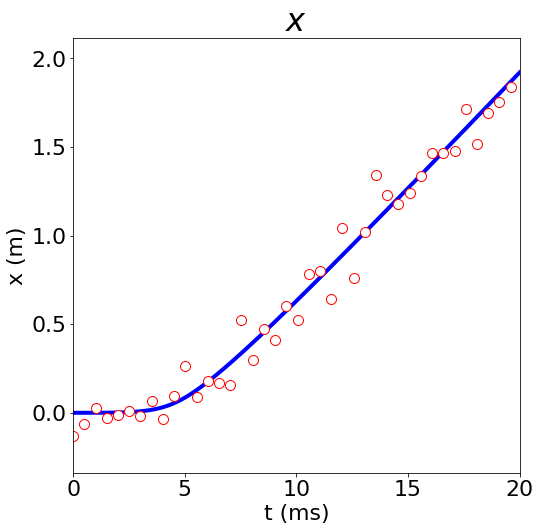

In [6]:

plt.figure(figsize=(8,8))
Xexp = z[:,0] + (np.random.normal(0, .1, N))
plt.plot(t*1E3,z[:,0],'b',linewidth=4)
plt.plot(t*1E3,Xexp,'ro',markevery=5,markerfacecolor='w',markersize= 10)
plt.xlim(0,20)
plt.title('${\it x}$',fontsize=32)
plt.ylabel('x (m)',size=22)
plt.xlabel('t (ms)',size=22)
plt.tick_params(axis="x", labelsize=22)
plt.tick_params(axis="y", labelsize=22)
plt.savefig('X.eps')

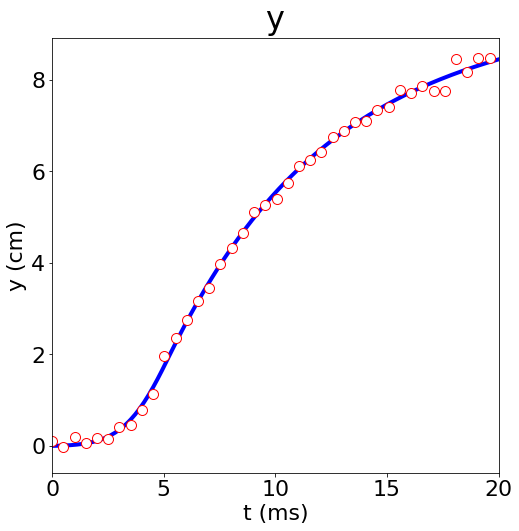

In [21]:

plt.figure(figsize=(8,8))
Yexp = z[:,1] + (np.random.normal(0, .001, N))
plt.plot(t*1E3,z[:,1]*1E2,'b',linewidth=4)
plt.plot(t*1E3,Yexp*1E2,'ro',markevery=5,markerfacecolor='w',markersize= 10)
plt.xlim(0,20)
plt.title('$\mathrm{y}$',fontsize=32)
plt.ylabel('y (cm)',size=22)
plt.xlabel('t (ms)',size=22)
plt.tick_params(axis="x", labelsize=22)
plt.tick_params(axis="y", labelsize=22)
plt.savefig('Y.eps')

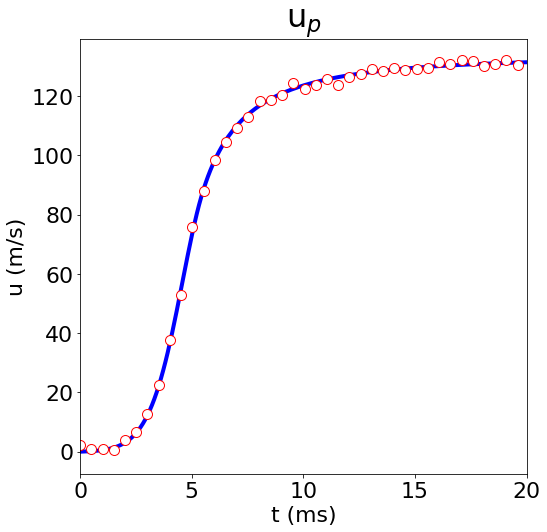

In [8]:

plt.figure(figsize=(8,8))
Uexp = z[:,2] + (np.random.normal(0, 1, N))
plt.plot(t*1E3,z[:,2],'b',linewidth=4)
plt.plot(t*1E3,Uexp,'ro',markevery=5,markerfacecolor='w',markersize= 10)
plt.xlim(0,20)
plt.title('$\mathrm{u}_p$',fontsize=32)
plt.ylabel('u (m/s)',size=22)
plt.xlabel('t (ms)',size=22)
plt.tick_params(axis="x", labelsize=22)
plt.tick_params(axis="y", labelsize=22)
plt.savefig('U.eps')

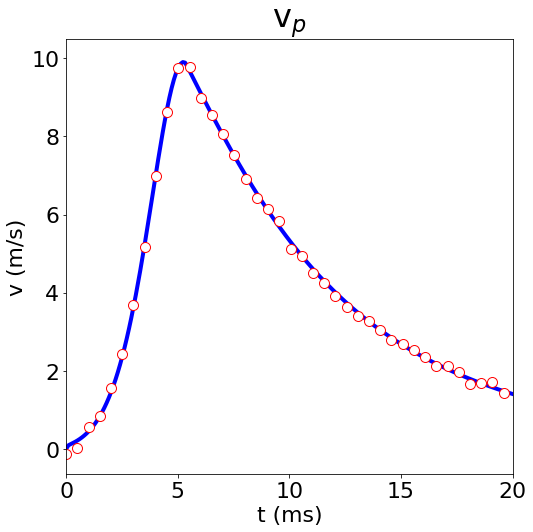

In [9]:

plt.figure(figsize=(8,8))
Vexp = z[:,3] + (np.random.normal(0,.1, N))
plt.plot(t*1E3,z[:,3],'b',linewidth=4)
plt.plot(t*1E3,Vexp,'ro',markevery=5,markerfacecolor='w',markersize= 10)
plt.xlim(0,20)
plt.title('$\mathrm{v}_p$',fontsize=32)
plt.ylabel('v (m/s)',size=22)
plt.xlabel('t (ms)',size=22)
plt.tick_params(axis="x", labelsize=22)
plt.tick_params(axis="y", labelsize=22)
plt.savefig('V.eps')

# Parameter Selection

In [10]:
def PS_model(t,D_p,Cs,Rho_g,Rho_p,nu):

    # initial condition
    z0 = [0,15E-6,0,0]
    
    params = Parameters()
    params.add('D_p'     , value = D_p      , vary=False)
    params.add('Cs'      , value = Cs       , vary=False)
    params.add('Rho_g'   , value = Rho_g    , vary=False)
    params.add('Rho_p'   , value = Rho_p    , vary=False)
    params.add('nu'      , value = nu       , vary=False)

    z = g(t,z0,params)
    return(z[:,0])

In [11]:

problem = {
    'num_vars':5,
    'names':['D_p','Cs','Rho_g','Rho_p','nu'],
    'bounds':[[0,1]]*5
}

param_values =saltelli.sample(problem,2**6)

#evaluate
x = np.linspace(0,.02,200)
y = np.array([PS_model(x, *params) for params in param_values])
#y = np.array([T(x, *params) for params in param_values])

# Analyze
sobol_indices = [sobol.analyze(problem, Y) for Y in y.T]

/home/prao/anaconda3/lib/python3.8/site-packages/SALib/analyze/sobol.py:96: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()


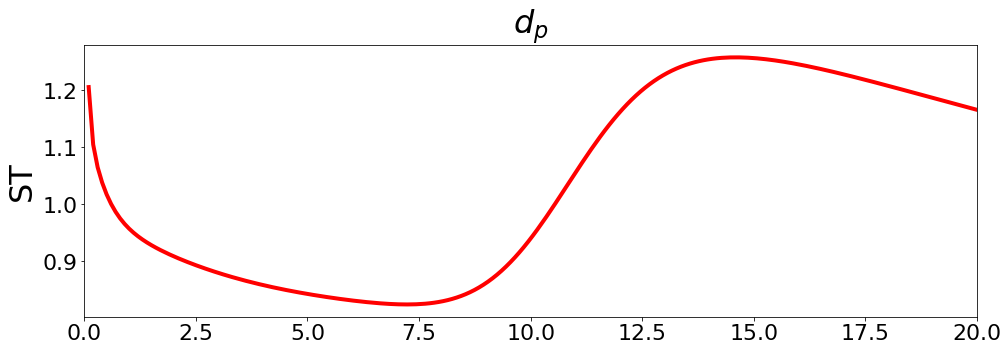

In [12]:
S1s = np.array([s['ST'] for s in sobol_indices])


plt.figure(figsize=(16,5))
plt.title('$d_p$',fontsize=32)

i=0
plt.plot(x*1E3, S1s[:, i],
            color='red',linewidth=4)
#plt.xlabel("t (ms)",fontsize=22)
plt.ylabel("ST" ,fontsize =32)
plt.tick_params(axis="x", labelsize=22)
plt.tick_params(axis="y", labelsize=22)
plt.xlim(0,20)
plt.savefig("Dp_sobol.eps")

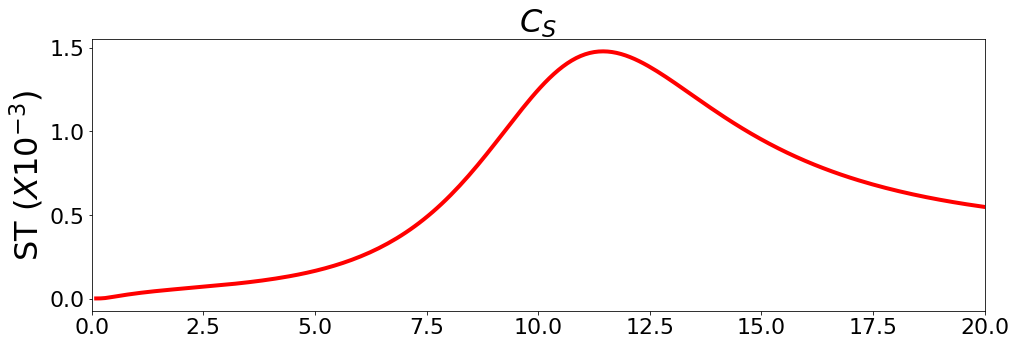

In [13]:
plt.figure(figsize=(16,5))
plt.title('$C_S$',fontsize=32)

i=1
plt.plot(x*1E3, S1s[:, i]*1E3,
            color='red',linewidth=4)
#plt.xlabel("t (ms)",fontsize=22)
plt.ylabel("ST $(X 10^{-3})$" ,fontsize =32)
plt.tick_params(axis="x", labelsize=22)
plt.tick_params(axis="y", labelsize=22)
plt.xlim(0,20)
plt.savefig("Cs_sobol.eps")

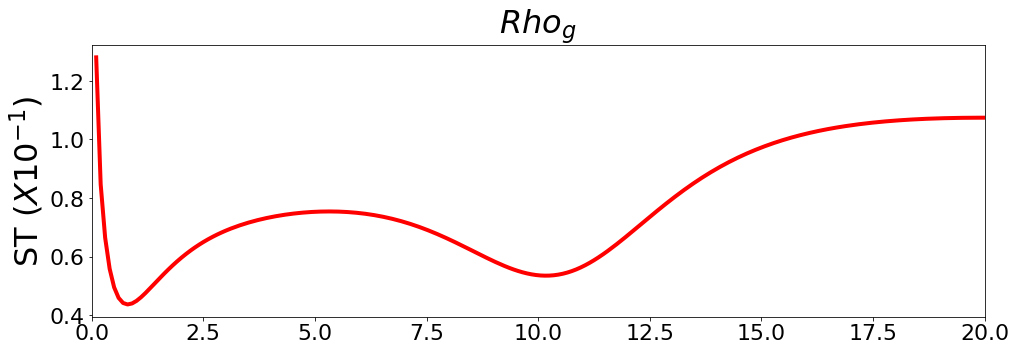

In [14]:
plt.figure(figsize=(16,5))
plt.title('$Rho_g$',fontsize=32)

i=2
plt.plot(x*1E3, S1s[:, i]*10,
            color='red',linewidth=4)
#plt.xlabel("t (ms)",fontsize=22)
plt.ylabel("ST $(X 10^{-1})$" ,fontsize =32)
plt.tick_params(axis="x", labelsize=22)
plt.tick_params(axis="y", labelsize=22)
plt.xlim(0,20)
plt.savefig("Rhog_sobol.eps")

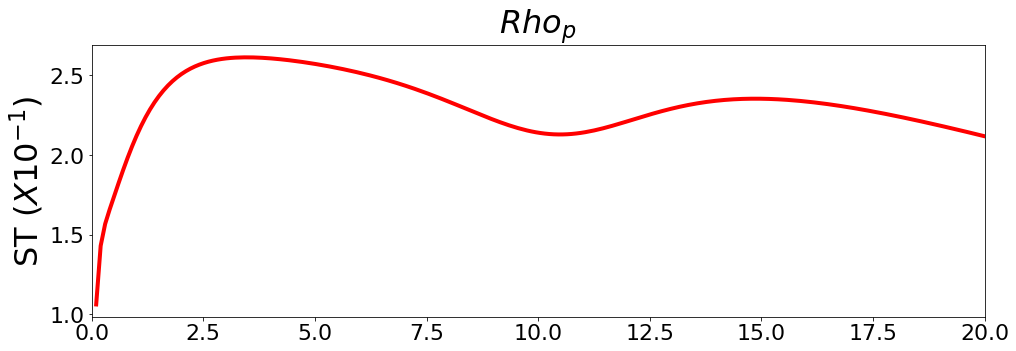

In [15]:
plt.figure(figsize=(16,5))
plt.title('$Rho_p$',fontsize=32)

i=3
plt.plot(x*1E3, S1s[:, i]*10,
            color='red',linewidth=4)
#plt.xlabel("",fontsize=22)
plt.ylabel("ST $(X 10^{-1})$" ,fontsize =32)
plt.tick_params(axis="x", labelsize=22)
plt.tick_params(axis="y", labelsize=22)
plt.xlim(0,20)
plt.savefig("Rhop_sobol.eps")

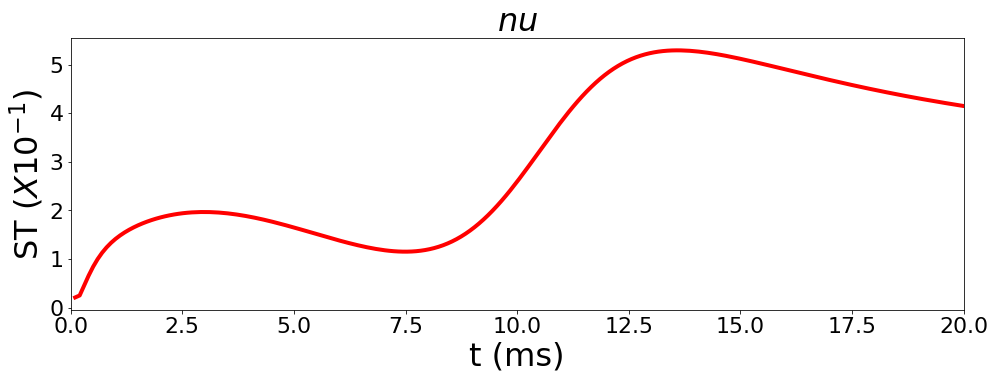

In [16]:
plt.figure(figsize=(16,5))
plt.title('$nu$',fontsize=32)

i=4
plt.plot(x*1E3, S1s[:, i]*10,
            color='red',linewidth=4)
plt.xlabel("t (ms)",fontsize=32)
plt.ylabel("ST $(X 10^{-1})$" ,fontsize =32)
plt.tick_params(axis="x", labelsize=22)
plt.tick_params(axis="y", labelsize=22)
plt.xlim(0,20)
plt.savefig("Nu_sobol.eps")

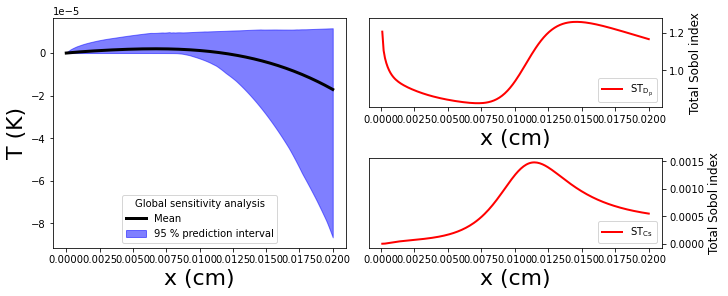

In [17]:


S1s = np.array([s['ST'] for s in sobol_indices])

fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

for i, ax in enumerate([ax1, ax2]):
    ax.plot(x, S1s[:, i],
            label=r'ST$_\mathregular{{{}}}$'.format(problem["names"][i]),
            color='red',linewidth=2)
    ax.set_xlabel("x (cm)",fontsize=22)
    ax.set_ylabel("Total Sobol index" ,fontsize =12)

    #ax.set_ylim(0, 1.04)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.legend(loc='lower right')

ax0.plot(x, np.mean(y, axis=0), label="Mean", color='black',linewidth=3)

# in percent
prediction_interval = 95

ax0.fill_between(x,
                 np.percentile(y, 50 - prediction_interval/2., axis=0),
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.5, color='blue',
                 label=f"{prediction_interval} % prediction interval")

ax0.set_xlabel("x (cm)", fontsize = 22)
ax0.set_ylabel("T (K)" ,fontsize=22)
ax0.legend(title=r"Global sensitivity analysis",
           loc='lower center')._legend_box.align = "center"


In [18]:
sobol_indices


[{'S1': array([nan, nan, nan, nan, nan]),
  'S1_conf': array([nan, nan, nan, nan, nan]),
  'ST': array([nan, nan, nan, nan, nan]),
  'ST_conf': array([nan, nan, nan, nan, nan]),
  'S2': array([[nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan]]),
  'S2_conf': array([[nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan]])},
 {'S1': array([ 8.32515628e-01, -4.30668364e-05,  1.38661901e-02,  5.60375325e-02,
          1.64720320e-02]),
  'S1_conf': array([1.02421326e+00, 6.62353393e-05, 5.61641512e-02, 8.96852765e-02,
         2.54510973e-02]),
  'ST': array([1.20503674e+00, 8.19594812e-07, 1.28004177e-01, 1.06287753e-01,
         2.09395524e-02]),
  'ST_conf': array([7.76906205e-01, 1.41243646e-06, 1.61814674e-01, 2.50111635e-01,
         4.64826668e-02]),
 

In [19]:


problem = {
    'num_vars':2,
    'names':['Phi','h'],
    'bounds':[[0,1]]*2
}

param_values =saltelli.sample(problem,2**6)

#evaluate
x = np.linspace(0,70,100)
y = np.array([T(x, *params) for params in param_values])

# Analyze
sobol_indices = [sobol.analyze(problem, Y) for Y in y.T]

np.shape(y)

NameError: name 'T' is not defined